In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pickle
import sys
from pathlib import Path

import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots

# torch.set_printoptions(precision=8, sci_mode=False, edgeitems=5)
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)


from tueplots import bundles, fontsizes, figsizes

from wbml import plot

plt.rcParams.update({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()})
matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots
# plt.rcParams.update(bundles.neurips2022())

In [5]:
matplotlib.get_cachedir()

'/Users/maxbronckers/.matplotlib'

### Locations

Read log files

In [6]:
main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
def load_exp(folder):
    preds_dir = os.path.join(main_dir, folder, "model")
    file_name = 'eval_domain_preds.csv'
    preds_file = os.path.join(preds_dir, file_name)

    train_data = pd.read_csv(os.path.join(preds_dir, "training_data.csv"))
    preds = pd.read_csv(preds_file)
    
    if folder.split('/')[-1].split('_')[1].split('-')[1] == 'pvi':
        q_type = 'GI'
    else:
        q_type = 'MFVI'

    return preds, train_data, q_type

In [15]:
folder = "narratives/rand_mean_init/07-30-09.34.14_seq-mfvi-ober-1c-2g-1000l-nealprior-80n-40b-0-02lr-2s-998-0nz-gvi"

In [16]:
preds, train_data, q_type = load_exp(folder)

data = preds
quartiles = np.quantile(preds.loc[:, preds.columns.str.startswith('preds_')], np.array((0.02275, 0.15865, 0.84135, 0.97725)), axis=1)
x_sorted, q0, q1, q2, q3 = zip(*sorted(zip(data['x_eval'], quartiles[0, :], quartiles[1, :], quartiles[2, :], quartiles[3, :])))

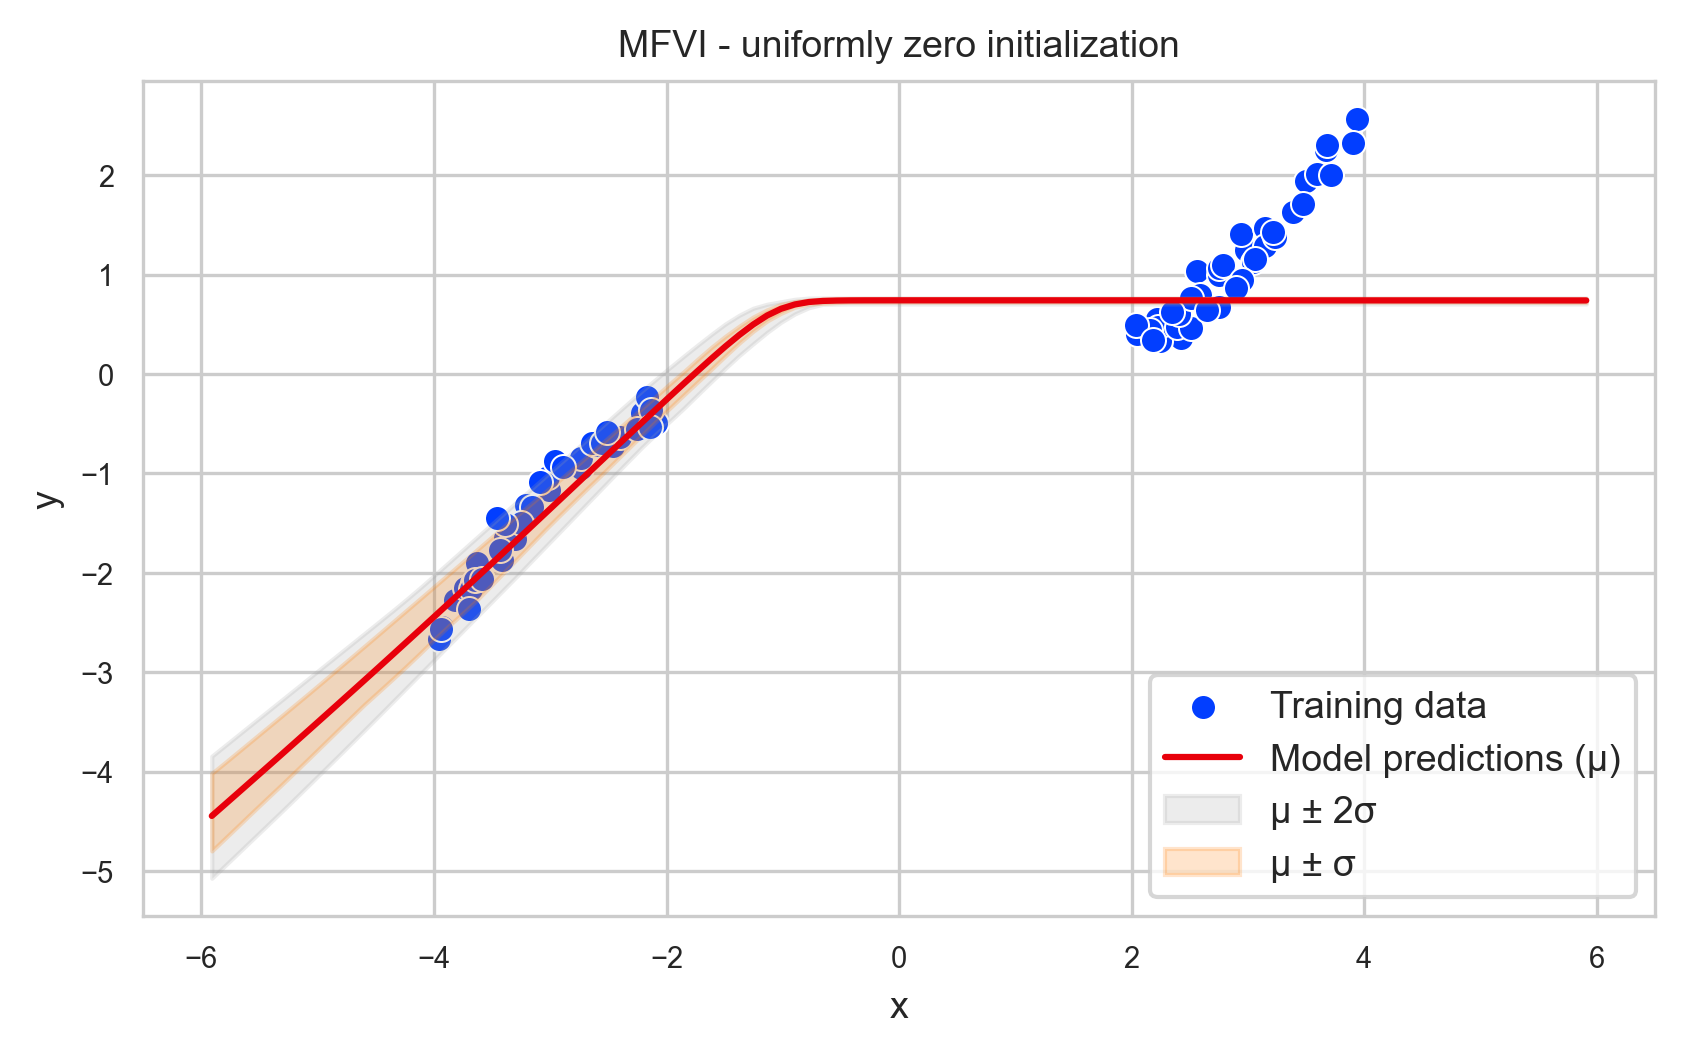

In [39]:
fig, ax = plt.subplots(1, 1)

x_metric = 'x_eval'
y_metric = 'y_pred_mean'

sns.scatterplot(data=train_data, x='x_tr', y='y_tr', ax=ax, label="Training data")
sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, label="Model predictions (μ)", color=colors[3])

x_sorted, q0, q1, q2, q3 = zip(*sorted(zip(data[x_metric], quartiles[0, :], quartiles[1, :], quartiles[2, :], quartiles[3, :])))
ax.fill_between(x_sorted, q0, q3, color=colors[7], alpha=0.20, label="μ ± 2σ")
ax.fill_between(x_sorted, q1, q2, color=colors[1], alpha=0.20, label="μ ± σ")

# ax.set_title(f'{q_type} - ' + r'$\mathcal{N}(0,1)$ initialization')
ax.set_title(f'{q_type} - uniformly zero initialization')

ax.set_ylabel(' '.join(y_metric.split('_')[0]))
ax.set_xlabel(' '.join(x_metric.split('_')[0]))
ax.legend(loc="lower right", prop={"size": 9})

plt.savefig(os.path.join(main_dir, folder, "plot"), pad_inches=0.2, bbox_inches="tight")
plt.show()



In [7]:
def plot_q(f, ax):
    x_metric = 'x_eval'
    y_metric = 'y_pred_mean'

    preds, train_data, q_type = load_exp(f)
    data = preds
    
    # Plot
    sns.scatterplot(data=train_data, x='x_tr', y='y_tr', ax=ax, s=8)
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, color=colors[3])

    # Quartiles
    quartiles = np.quantile(preds.loc[:, preds.columns.str.startswith('preds_')], np.array((0.02275, 0.15865, 0.84135, 0.97725)), axis=1)
    x_sorted, q0, q1, q2, q3 = zip(*sorted(zip(data['x_eval'], quartiles[0, :], quartiles[1, :], quartiles[2, :], quartiles[3, :])))
    ax.fill_between(x_sorted, q0, q3, color=colors[7], alpha=0.20, label="μ ± 2σ")
    ax.fill_between(x_sorted, q1, q2, color=colors[1], alpha=0.20, label="μ ± σ")

    # ax.set_title(f'{q_type}')    
    ax.set_ylabel(' '.join(y_metric.split('_')[0]))
    ax.set_xlabel(' '.join(x_metric.split('_')[0]))

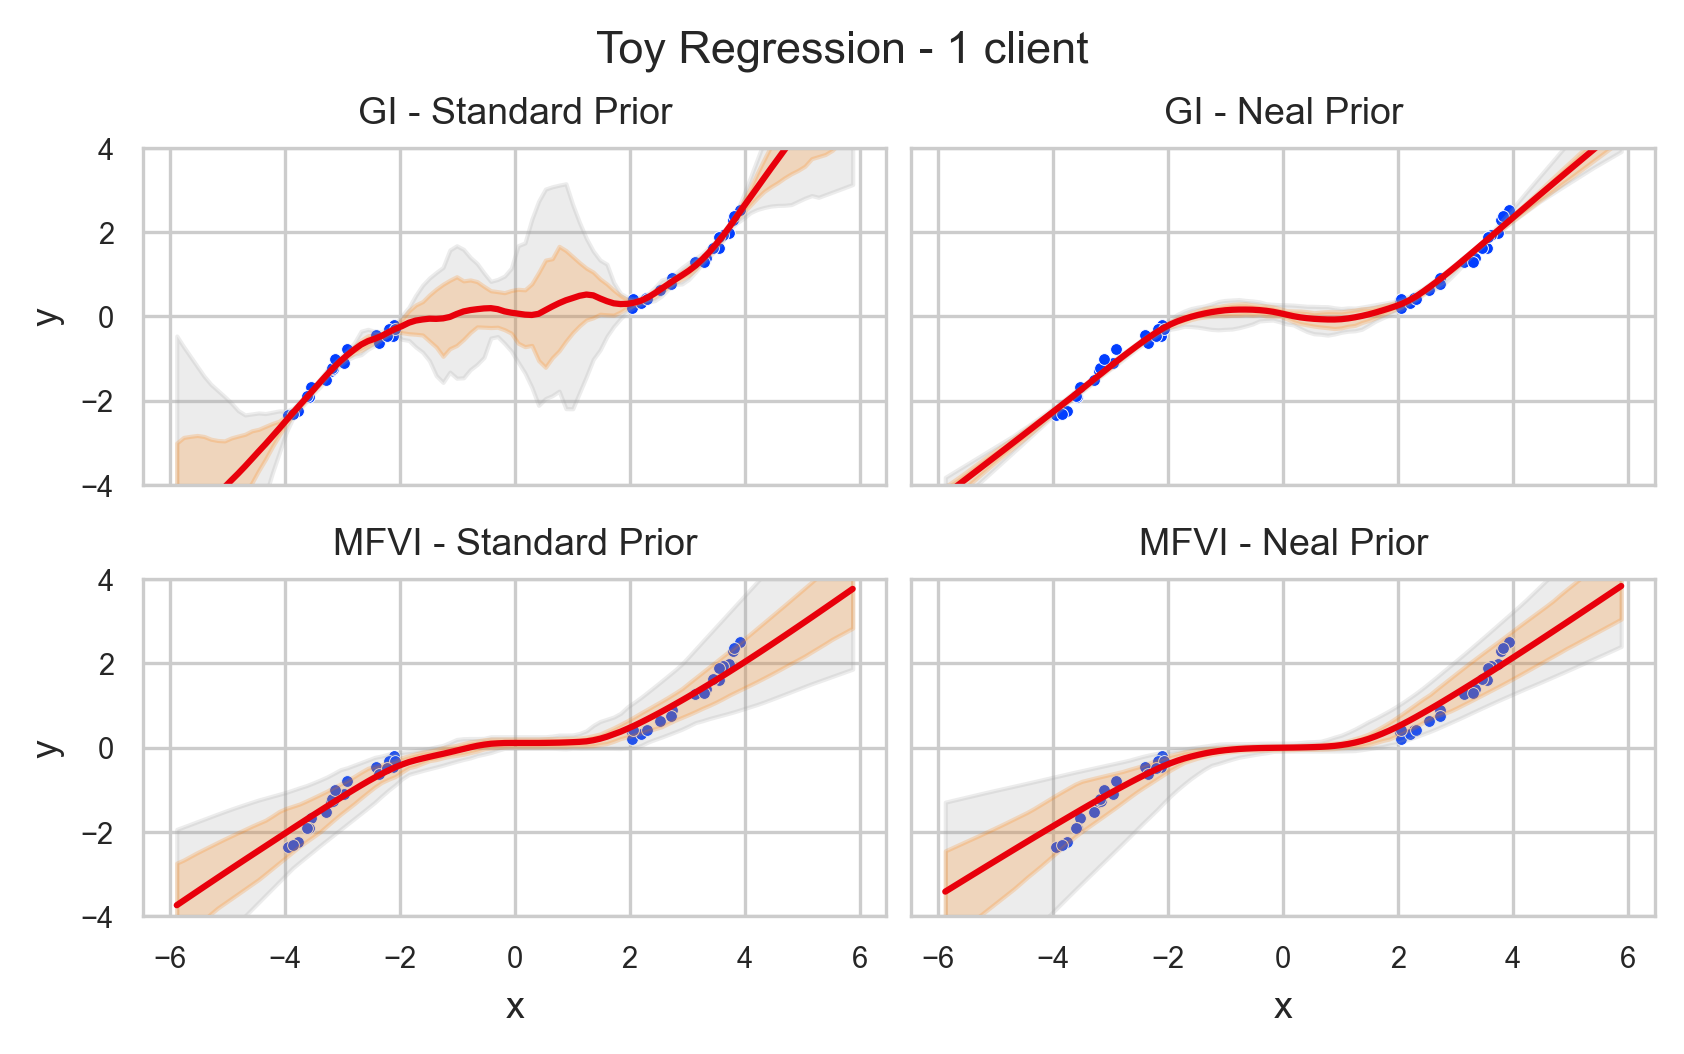

In [9]:
folders = {
            "TL": "results_new/Toy/08-02-08.55.15_seq-pvi-ober-1c-1g-5000l-standardprior-40n-40b-0-01lr-10s-40m-1nz",
            "TR": "results_new/Toy/08-02-08.48.48_seq-pvi-ober-1c-1g-5000l-nealprior-40n-40b-0-01lr-10s-40m-1nz", 
            "BL": "results_new/Toy/08-02-09.31.33_seq-mfvi-ober-1c-1g-5000l-standardprior-40n-40b-0-05lr-10s-998-0nz",
            "BR": "results_new/Toy/08-02-09.23.11_seq-mfvi-ober-1c-1g-5000l-nealprior-40n-40b-0-05lr-10s-1nz",
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Toy Regression - 1 client")

axes = {"TL": axs[0,0], "TR": axs[0,1], "BL": axs[1,0], "BR": axs[1,1]}
for loc, f in folders.items():
    if f != "":
        plot_q(f, axes[loc])

axes[loc].set_ylim((-4, 4))

# IF you want titles, do it here:
titles = {"TL": "GI - Standard Prior", "TR": "GI - Neal Prior", "BL": "MFVI - Standard Prior", "BR": "MFVI - Neal Prior"}
for loc, ax_title in titles.items():
    if ax_title != "":
        axes[loc].set_title(ax_title)
plt.show()

# MFVI Hypers

<>:19: DeprecationWarning: invalid escape sequence \e
<>:19: DeprecationWarning: invalid escape sequence \e
/var/folders/ql/5nr7rnkx6ws9qmnn9phw19sh0000gn/T/ipykernel_9759/1552382381.py:19: DeprecationWarning: invalid escape sequence \e
  titles = {"BR": "StdPrior - $\eta=0.02$, $\sigma^2 = 1$", "TR": r'$\eta=0.02$, $\sigma^2=0.001$', "TL": r'$\eta=0.02$, $\sigma^2 = 1$', "BL": r'$\eta=0.02$, $\sigma^2 = 54$'}


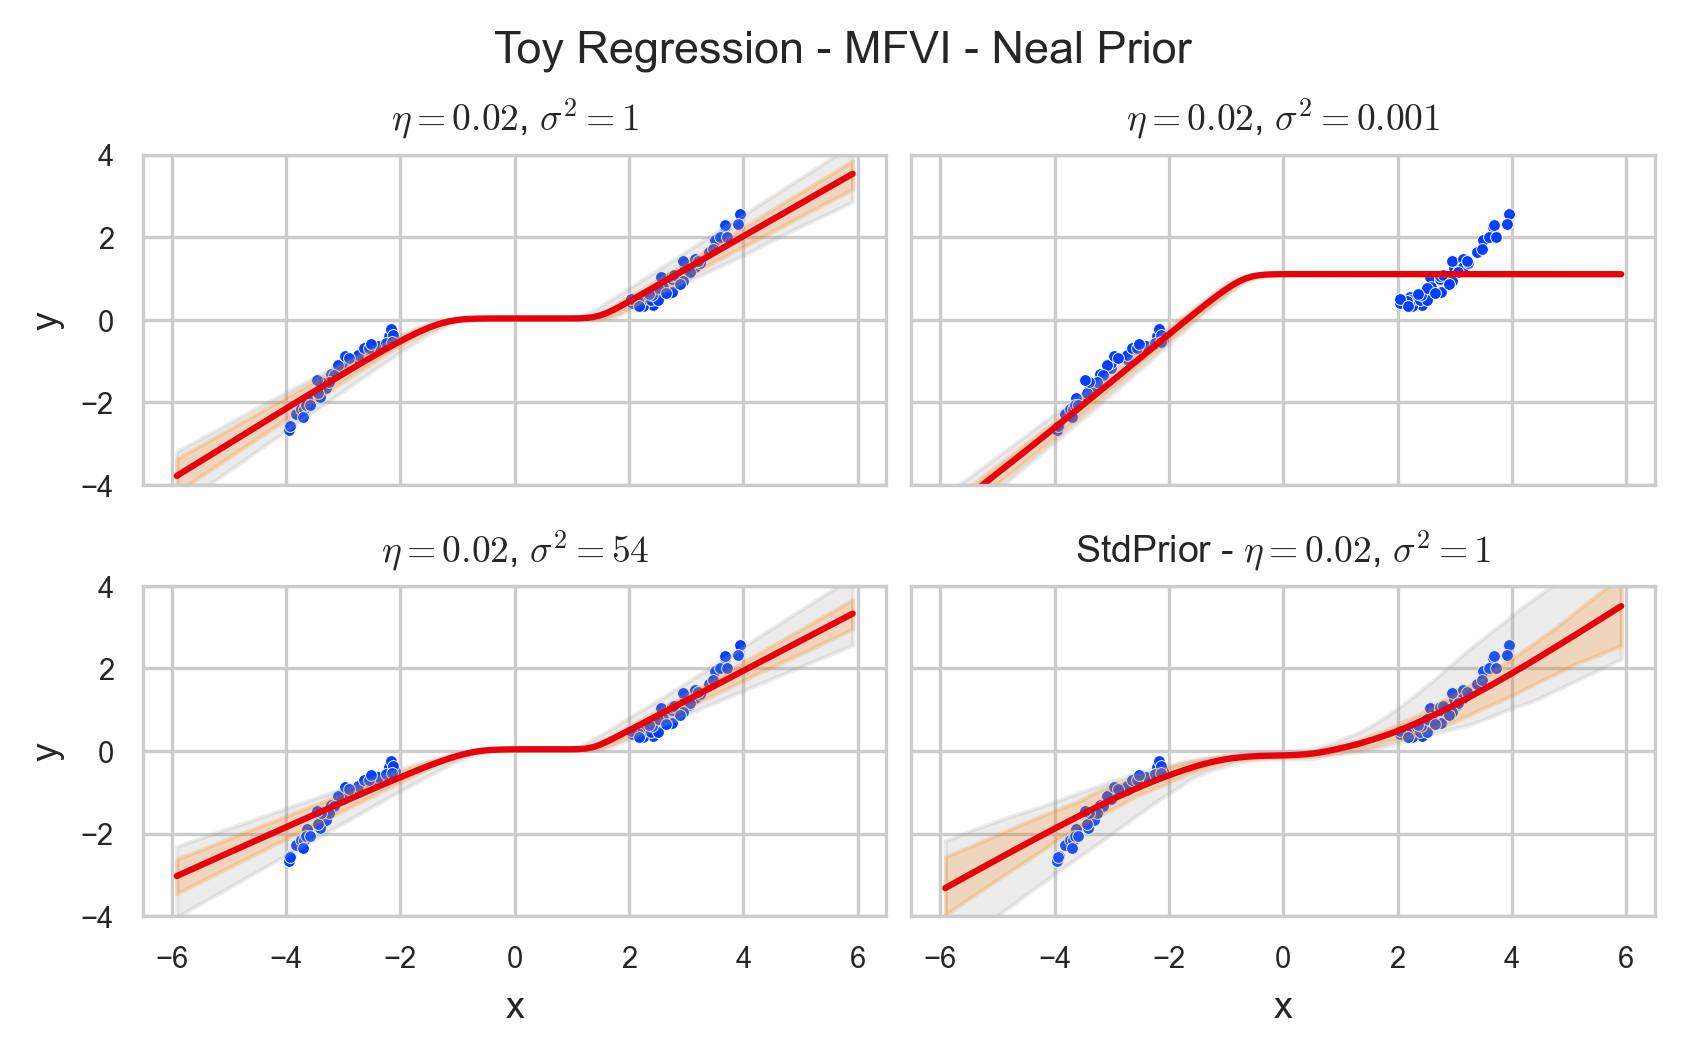

In [28]:
folders = {
            
            "TR": "narratives/1D_hypers_effects/07-29-14.49.17_seq-mfvi-ober-2c-2g-1000l-nealprior-80n-40b-0-02lr-2s-40m-998-0nz",
            "TL": "narratives/1D_hypers_effects/07-29-14.46.28_seq-mfvi-ober-2c-2g-1000l-nealprior-80n-40b-0-02lr-2s-40m-1nz",
            "BL": "narratives/1D_hypers_effects/07-29-14.48.09_seq-mfvi-ober-2c-2g-1000l-nealprior-80n-40b-0-02lr-2s-40m-0-01831563888873418nz",
            "BR": "narratives/1D_hypers_effects/07-29-14.37.18_seq-mfvi-ober-2c-2g-1000l-standardprior-80n-40b-0-02lr-2s-40m-1nz",
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Toy Regression - MFVI - Neal Prior")

axes = {"TL": axs[0,0], "TR": axs[0,1], "BL": axs[1,0], "BR": axs[1,1]}
for loc, f in folders.items():
    if f != "":
        plot_q(f, axes[loc])

axes[loc].set_ylim((-4, 4))

titles = {"BR": "StdPrior - $\eta=0.02$, $\sigma^2 = 1$", "TR": r'$\eta=0.02$, $\sigma^2=0.001$', "TL": r'$\eta=0.02$, $\sigma^2 = 1$', "BL": r'$\eta=0.02$, $\sigma^2 = 54$'}
for loc, ax_title in titles.items():
    if ax_title != "":
        axes[loc].set_title(ax_title)


plt.savefig(os.path.join(main_dir, "narratives/1D_hypers_effects/", "neal_prior"), pad_inches=0.2, bbox_inches="tight")
plt.show()

<>:18: DeprecationWarning: invalid escape sequence \e
<>:18: DeprecationWarning: invalid escape sequence \e
/var/folders/ql/5nr7rnkx6ws9qmnn9phw19sh0000gn/T/ipykernel_9759/3317037786.py:18: DeprecationWarning: invalid escape sequence \e
  titles = {"BR": "$\eta=0.05$, $\sigma^2 = 1$", "TR": r'$\eta=0.02$, $\sigma^2=0.001$', "TL": r'$\eta=0.02$, $\sigma^2 = 1$', "BL": r'$\eta=0.02$, $\sigma^2 = 54$'}


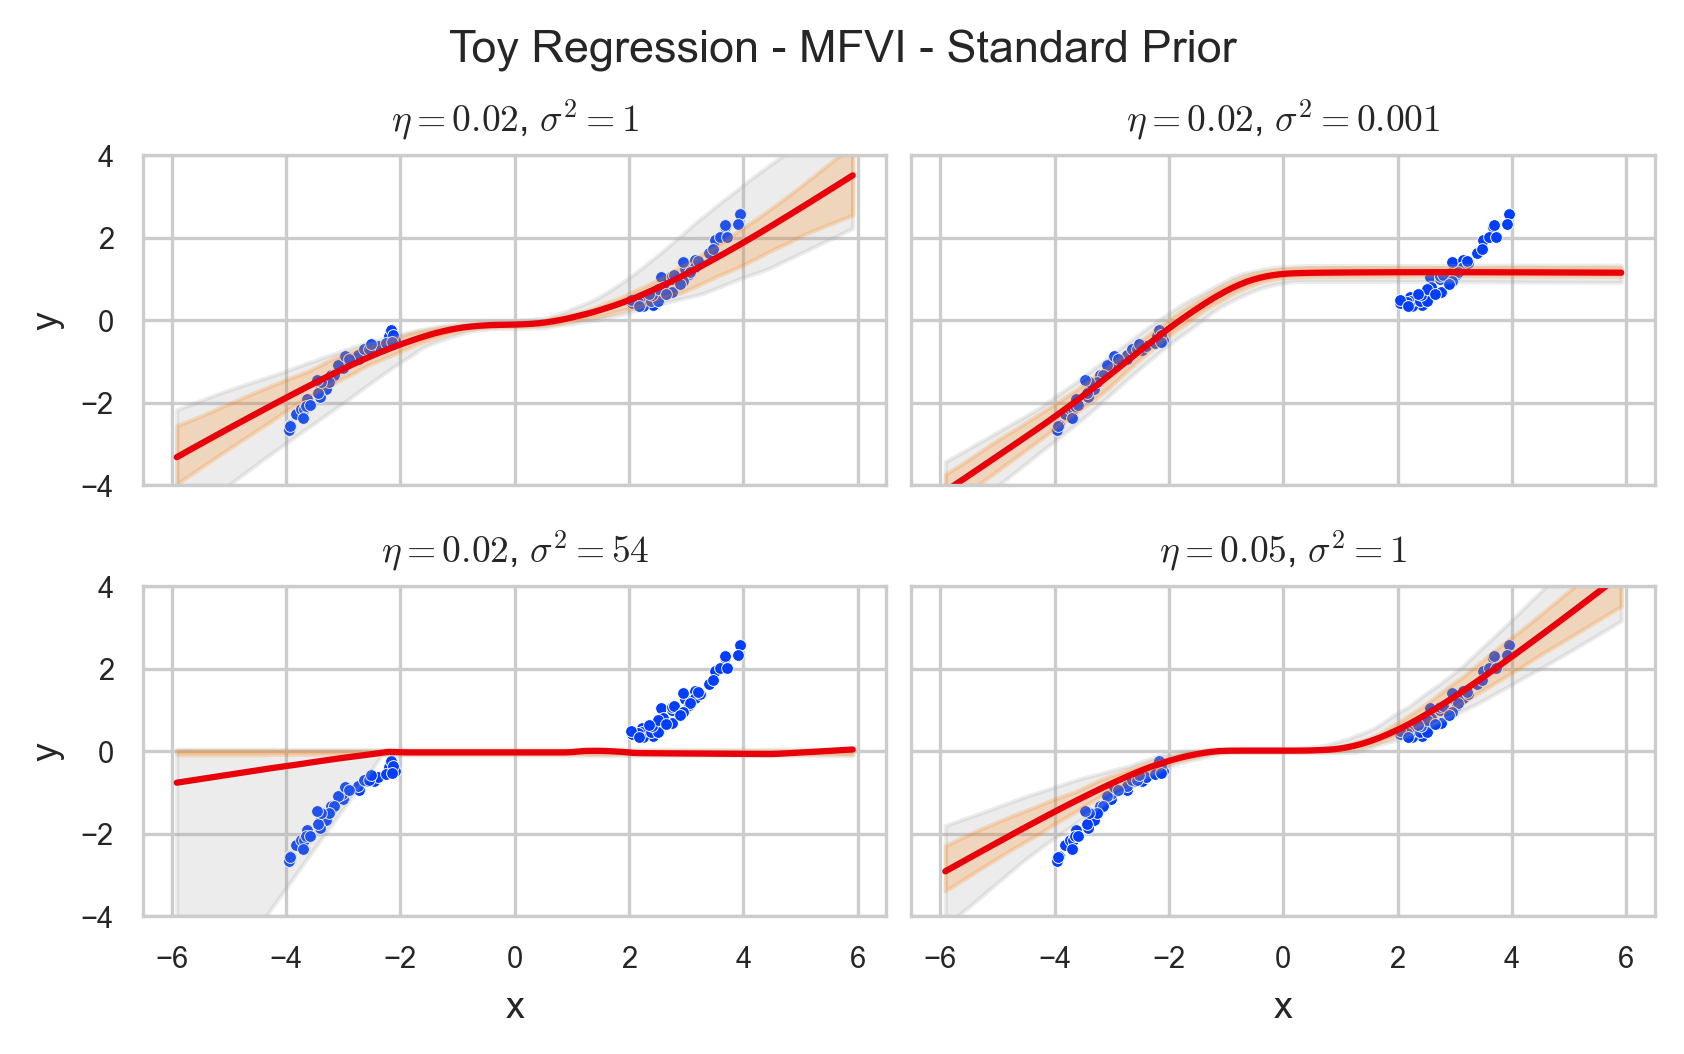

In [29]:
folders = {
            "TL": "narratives/1D_hypers_effects/07-29-14.37.18_seq-mfvi-ober-2c-2g-1000l-standardprior-80n-40b-0-02lr-2s-40m-1nz",
            "TR": "narratives/1D_hypers_effects/07-29-14.45.21_seq-mfvi-ober-2c-2g-1000l-standardprior-80n-40b-0-02lr-2s-40m-998-0nz",
            "BR": "narratives/1D_hypers_effects/07-29-14.38.17_seq-mfvi-ober-2c-2g-1000l-standardprior-80n-40b-0-05lr-2s-40m-1nz", 
            "BL": "narratives/1D_hypers_effects/07-29-14.41.50_seq-mfvi-ober-2c-2g-1000l-standardprior-80n-40b-0-02lr-2s-40m-0-01831563888873418nz",
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Toy Regression - MFVI - Standard Prior")

axes = {"TL": axs[0,0], "TR": axs[0,1], "BL": axs[1,0], "BR": axs[1,1]}
for loc, f in folders.items():
    if f != "":
        plot_q(f, axes[loc])

axes[loc].set_ylim((-4, 4))

titles = {"BR": "$\eta=0.05$, $\sigma^2 = 1$", "TR": r'$\eta=0.02$, $\sigma^2=0.001$', "TL": r'$\eta=0.02$, $\sigma^2 = 1$', "BL": r'$\eta=0.02$, $\sigma^2 = 54$'}
for loc, ax_title in titles.items():
    if ax_title != "":
        axes[loc].set_title(ax_title)


plt.savefig(os.path.join(main_dir, "narratives/1D_hypers_effects/", "neal_prior"), pad_inches=0.2, bbox_inches="tight")
plt.show()

All Std prior with different likelihood variance 